# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [20]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
import seaborn as sns

#Paso 1. Hacer la solicitud a la URL
url = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"
html_data = requests.get(url, time.sleep(15)).text

# If no information is extracted, then connect as anonymous
if "403 Forbidden" in html_data:
    headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"}
    request = requests.get(url, headers = headers)
    time.sleep(15)
    html_data = request.text

#Paso 2. Parsear el HTML con BeutifulSoup
with open("revenues.html", "r", encoding ="utf-8") as file: # 'utf-8' is common but may need adjustment
  html_content = file.read()

soup = BeautifulSoup(html_content, "html.parser")


# Paso 3. Encontrar todas las tablas y extraer cada una como DataFrame
tables = soup.find_all("table")
#print(f"Se encontraron {len(tables)} tablas.")

# Verificamos que haya al menos dos tablas
if len(tables) < 2:
    raise Exception("No se encontraron suficientes tablas en la página.")

# Extraer la segunda tabla
df = pd.read_html(str(tables[1]))[0]

# Paso 4. Renombrar columnas
df.columns = ["Date", "Revenue"]

# Paso 5. Limpiar los datos del DataFrame
# 1. Eliminar filas que contengan valores vacíos o nulos
df.dropna(inplace=True)

# 2. Limpiar la columna 'Revenue' eliminando símbolos de dólar y comas, y convertirla a numérico
df['Revenue'] = df['Revenue'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# 3. Convertir la columna 'Date' a formato datetime para facilitar análisis
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)  # Eliminar filas donde 'Date' no se pueda convertir

# Mostrar el DataFrame limpio
print("DataFrame limpio de la Tabla 2 con encabezados:")
df



DataFrame limpio de la Tabla 2 con encabezados:


/tmp/ipykernel_685/3964017879.py:35: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(tables[1]))[0]


,Date,Revenue
0,2024-09-30,25182.0
1,2024-06-30,25500.0
2,2024-03-31,21301.0
3,2023-12-31,25167.0
4,2023-09-30,23350.0
...,...,...
56,2010-09-30,31.0
57,2010-06-30,28.0
58,2010-03-31,21.0
60,2009-09-30,46.0


PRIMERO VISUALICEMOS LOS DATOS CON UN GRAFICO DE LINEAS QUE DEMUESTREN LA TENDENCIA DE INGRESOS A LO LARGO DEL TIEMPO


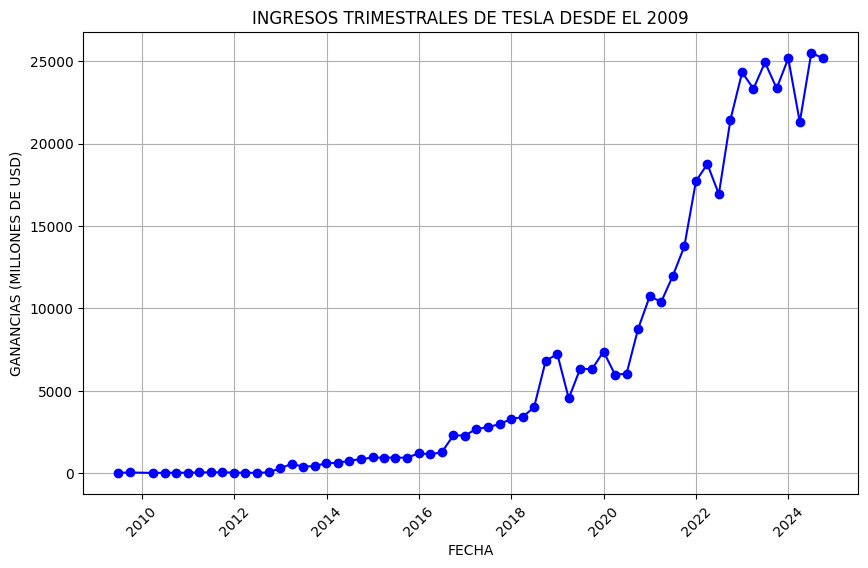

In [21]:
print("PRIMERO VISUALICEMOS LOS DATOS CON UN GRAFICO DE LINEAS QUE DEMUESTREN LA TENDENCIA DE INGRESOS A LO LARGO DEL TIEMPO")


plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Revenue'], color='blue', marker='o', linestyle='-')
plt.title("INGRESOS TRIMESTRALES DE TESLA DESDE EL 2009")
plt.xlabel("FECHA")
plt.ylabel("GANANCIAS (MILLONES DE USD)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

SEGUNDO VISUALICEMOS LOS DATOS CON UN GRAFICO DE BARRAS DONDE COMPARAMOS LOS INGRESOS POR AÑO


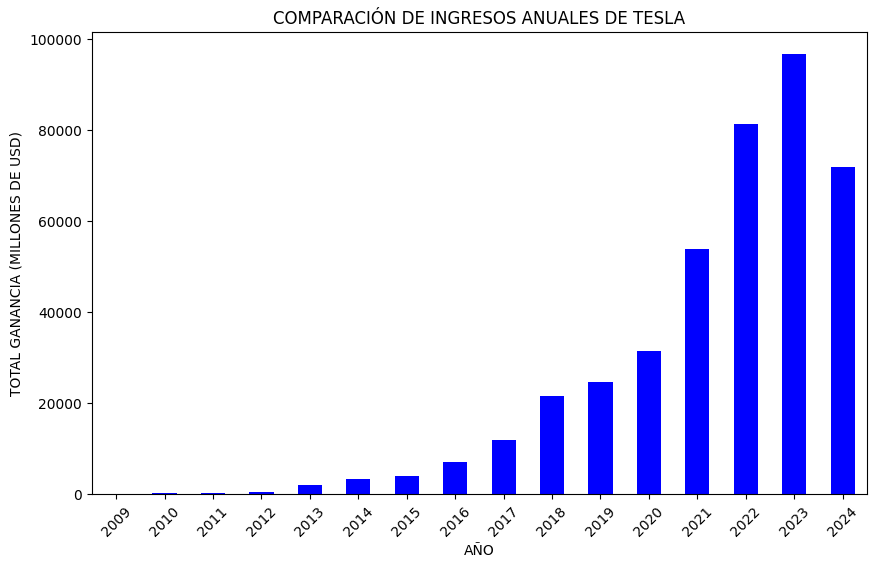

In [22]:
print("SEGUNDO VISUALICEMOS LOS DATOS CON UN GRAFICO DE BARRAS DONDE COMPARAMOS LOS INGRESOS POR AÑO")

# Crear una columna con solo el año para agrupar por año
df['Year'] = df['Date'].dt.year
annual_revenue = df.groupby('Year')['Revenue'].sum()

plt.figure(figsize=(10, 6))
annual_revenue.plot(kind='bar', color='blue')
plt.title("COMPARACIÓN DE INGRESOS ANUALES DE TESLA")
plt.xlabel("AÑO")
plt.ylabel("TOTAL GANANCIA (MILLONES DE USD)")
plt.xticks(rotation=45)
plt.show()

TERCERO VISUALICEMOS LOS DATOS CON UN GRAFICO DE LINEAS CON PROMEDIO MOVIL


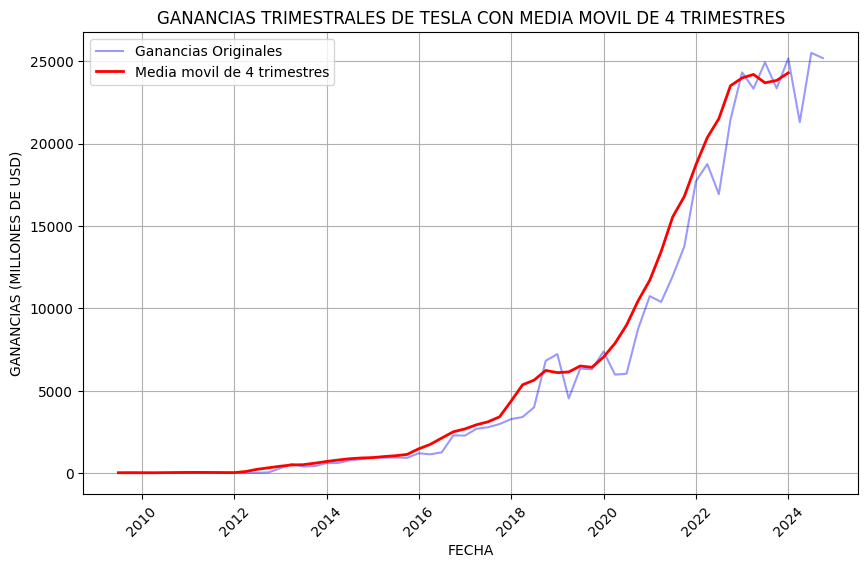

In [26]:
print("TERCERO VISUALICEMOS LOS DATOS CON UN GRAFICO DE LINEAS CON PROMEDIO MOVIL")
# Calcular un promedio móvil de 4 trimestres
df['Moving_Avg'] = df['Revenue'].rolling(window=4).mean()

plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Revenue'], color='blue', alpha=0.4, label="Ganancias Originales")
plt.plot(df['Date'], df['Moving_Avg'], color='red', linewidth=2, label="Media movil de 4 trimestres")
plt.title("GANANCIAS TRIMESTRALES DE TESLA CON MEDIA MOVIL DE 4 TRIMESTRES")
plt.xlabel("FECHA")
plt.ylabel("GANANCIAS (MILLONES DE USD)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

POR ÚLTIMO VISUALICEMOS LOS DATOS CON UN GRAFICO DE BARRAS APILADAS DONDE ANALIZAREMOS LOS  INGRESOS POR TRIMESTRE DENTRO DE CADA AÑO


<Figure size 1000x600 with 0 Axes>

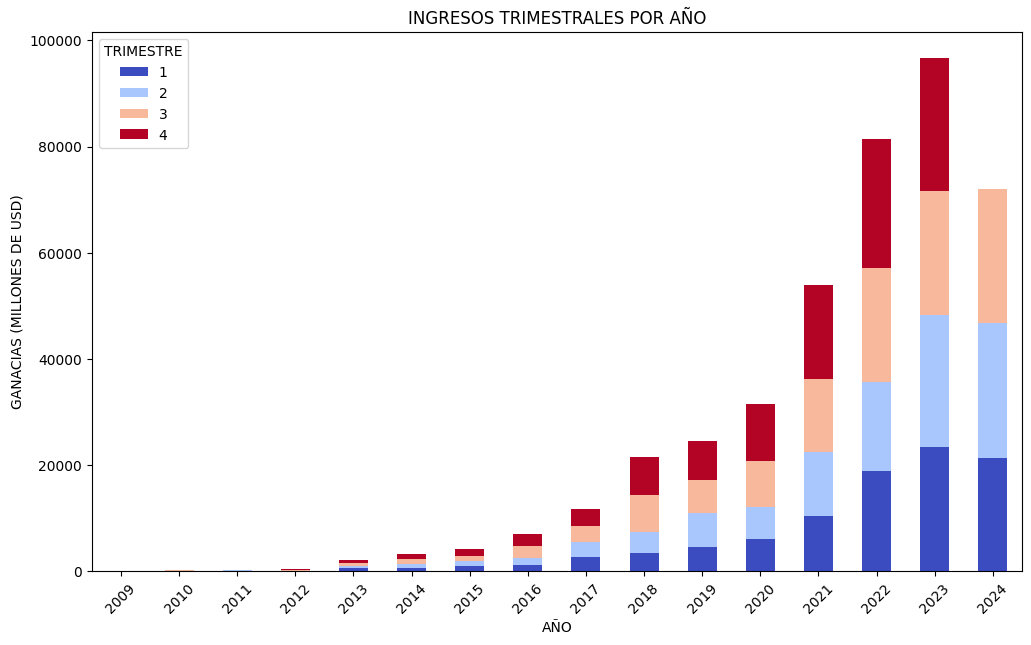

In [28]:
print("POR ÚLTIMO VISUALICEMOS LOS DATOS CON UN GRAFICO DE BARRAS APILADAS DONDE ANALIZAREMOS LOS  INGRESOS POR TRIMESTRE DENTRO DE CADA AÑO")
# Crear columnas de Año y Trimestre
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter
quarterly_revenue = df.pivot_table(index='Year', columns='Quarter', values='Revenue', aggfunc='sum')

plt.figure(figsize=(10, 6))
quarterly_revenue.plot(kind='bar', stacked=True, cmap='coolwarm', figsize=(12, 7))
plt.title("INGRESOS TRIMESTRALES POR AÑO")
plt.xlabel("AÑO")
plt.ylabel("GANACIAS (MILLONES DE USD)")
plt.legend(title="TRIMESTRE", loc="upper left")
plt.xticks(rotation=45)
plt.show()